In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean

# standard geospatial python utilities
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [4]:
from importlib import reload
def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
add_path(doc_dir+'/GitHub/flopy')

import flopy 
import flopy.utils.binaryfile as bf

In [5]:
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

from mf_utility import get_dates, get_layer_from_elev, clean_wb

In [6]:

def clean_sfr_df(model_ws, m_name,  drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['Gravel','Sand']).sum())
    
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m_name+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['num_coarse'] = num_coarse
    
    ## data transformation for easier manipulation ##
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient <= 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [7]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

upscale = 4 
upscale_txt = 'upscale'+str(upscale)+'x_'
# model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_'+upscale_txt+'2014_2018'

base_model_ws = join(loadpth,model_nam)

# all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_'+model_nam)

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [8]:
strt_date, end_date, dt_ref = get_dates(m.dis, ref='strt')

In [9]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'
# elevation to grid for reference to land surface
dem_data = np.loadtxt(join(proj_dir, 'GIS','local_subset_dem_52_9_200m_mean.tsv'))
grid_p['dem_elev'] = dem_data[grid_p.row-1, grid_p.column-1]

In [10]:
XSg = pd.read_csv(join(base_model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values


In [11]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))


In [12]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

In [13]:
# load previously made output to speed up reuse
sfr_3mon_all = pd.read_csv(join(out_dir, 'sfrdf_3month_mean.csv'), parse_dates=['dt'], index_col='dt')


Graham suggested we individually disect some of these results to better understand the impact of outcropping HCPs. A good presentation would be picking a realization that has low, middle, or high streamflow or by looking at the number of coarse segments since that is what is used as an independent variable in the correlation statistics. From there we can investigate the spatial aspects in some ways. Filter by looking at overall average streamflow at the outlet.

- look at location of coarse segments vs where baseflow/recharge happen.
- plot XS of channel to show heads in aquifer and stream and perhaps fluctuate over time to show how gravels change conditions

also looking at the best fit realization to show what reality is then diving into these other realizations to show how differences in spatial distribution can significantly alter stream function. The baseflow below here is a great example of how excess gravel scattered in the channel greatly increases connectivity and baseflow. We should demonstrate as well how this then plays into the timing and duration of in-stream flows to support the ecosystem.

In [14]:
stats_done = pd.read_csv(join(out_dir, 'hob_fit_stats.csv'),index_col=0)
top_rmse = stats_done[stats_done.RMSE<=stats_done.RMSE.quantile(0.03)]
top_rmse


,r2,RMSE,NSE
47,0.591254,1.846578,0.591643
65,0.596089,1.835623,0.596256
74,0.595135,1.837790,0.595571


In [25]:
# ref_out = pd.read_csv(join(proj_dir, 'coarse_reference.csv'), index_col=0)
ref_out = pd.read_csv(join(proj_dir, 'num_sfr_coarse.csv'), index_col=0)
ref_out=ref_out.rename(columns={'num_coarse':'num_sfr'})

In [26]:
sfr_last_mean = sfr_last_all.groupby('realization').mean(numeric_only=True)['Qout']
# realizations to review
def per_idx(sfr_last_mean, per):
    idx = sfr_last_mean[sfr_last_mean.isin(np.percentile(sfr_last_mean, per, method='nearest'))].sort_values().index.values
    return idx
quants = [5, 25, 50, 75, 95]
# categorize by streamflow
r_review = per_idx(sfr_last_mean, quants)

# categorize by the number of coarse segments
r_review = ref_out[ref_out.num_sfr.isin(np.percentile(ref_out.num_sfr, quants, method='nearest'))]
r_review = r_review.drop_duplicates('num_sfr').sort_values('num_sfr').index.values

# consider the best fit as well
r_review = pd.DataFrame(np.append(r_review, top_rmse.index.values), columns=['realization'])
r_review['variable'] = np.append(['quant']*len(quants), ['fit']*len(top_rmse))
r_review['value'] = np.append(quants, top_rmse.RMSE).round(4)
r_review['num_coarse'] = ref_out.loc[r_review.realization, 'num_sfr'].values
# r_review
# coarse_ref.loc[r_review], sfr_last_mean[r_review]

In [18]:
# ref_out.loc[r_review.realization, 'num_lak'].values

array([47, 14, 53, 27, 88, 38, 53, 25], dtype=int64)

In [27]:
grid_sfr_all = pd.DataFrame()
for r in r_review.realization: #100
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv',index_col=0)
    grid_sfr = grid_sfr.drop(columns=['node','geometry','node.1'])
    grid_p_sfr = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.i+1,grid_sfr.j+1))].reset_index(drop=True)
    grid_sfr = pd.concat((grid_p_sfr,grid_sfr),axis=1)
    grid_sfr_all = pd.concat((grid_sfr_all, grid_sfr.assign(realization=r)))

Looking at the quantiles for the number of coarse stream segments it seems that the best fit realizations span the 5th to 75th percentile which means that we have multiple realizations with different stream segment connections but equal model fit which means that the larger subsurface distribution might account for the fit more than stream segments that outcrop.
- the top best fit realizations both had a higher number of coarse lake cells
- the other variable to plot would be the number of distinct connected bodies that outcrop or that are in the domain

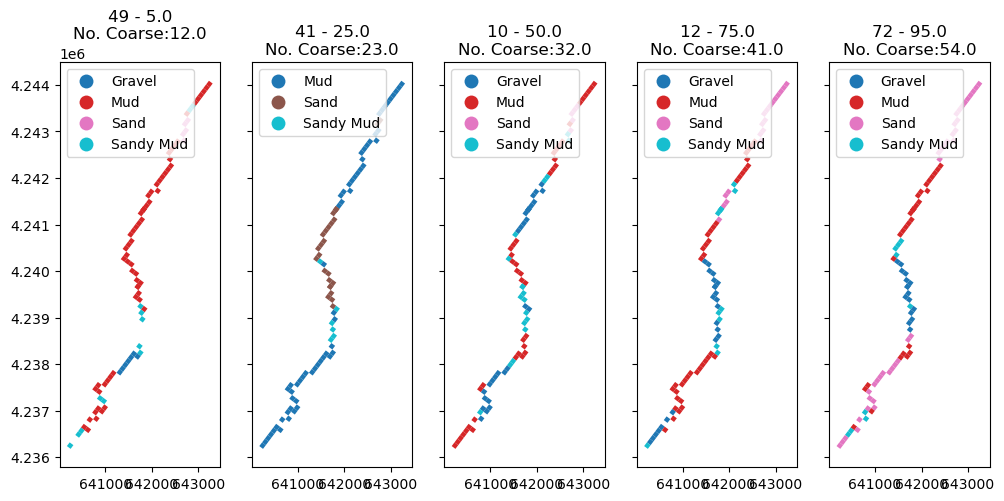

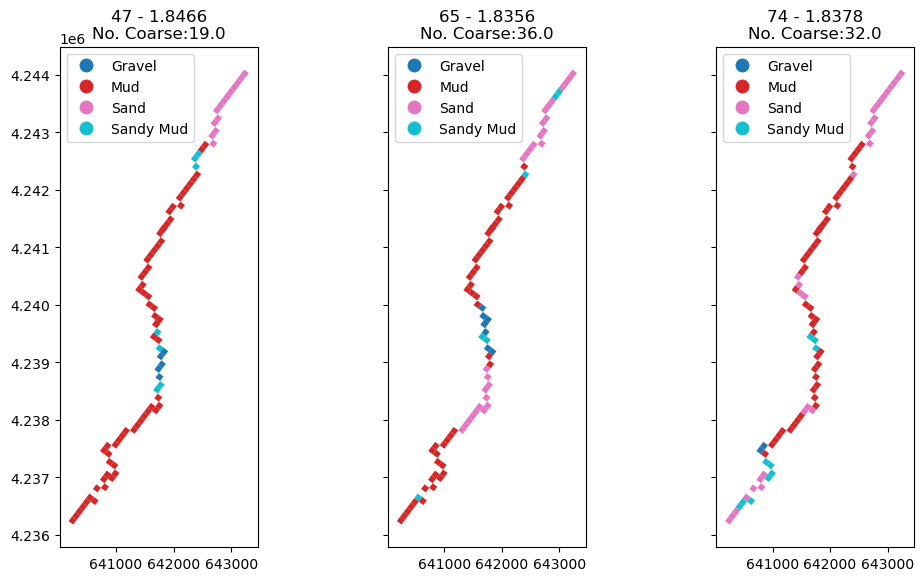

In [28]:
q_review = r_review[r_review.variable=='quant']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))
# grid_sfr_all[grid_sfr_all.realization==r].plot('facies', legend=True, ax=ax[-1])

q_review = r_review[r_review.variable=='fit']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))

In [141]:

# grid_sfr_all[grid_sfr_all.realization==11]
# m.name

'MF'

In [158]:
r=11
folder = 'realization'+ str(r).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
sfrdf =  clean_sfr_df(model_ws, m.name, drop_iseg)


The baseflow is too inconsistent to show as a time series since it is dominantly a 0 value. The seepage heat map is able to show how between realizations the days with 0 seepage expands across segments and time with more coarse segments generally.  
The streamflow values tend to be large such that you don't see much variability in the streamflow across segments unless the segment goes dry.

In [29]:
sfrdf_all = pd.DataFrame()
q_review = r_review[r_review.variable=='quant']
for nr, r in enumerate(q_review.realization):
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    sfrdf =  clean_sfr_df(model_ws, m.name, drop_iseg)
    sfrdf_all = pd.concat((sfrdf_all, sfrdf.assign(realization=r)))

In [30]:
def magnitude(x):
    return int(np.log10(x))


In [62]:
def heat_map(sfrdf_all, variable, var_name, q_review):
    fig,ax = plt.subplots(len(variable)+1, len(q_review), figsize=(12, 8), sharex=True, sharey='row', layout='constrained', dpi=300)
    for nv, v in enumerate(variable):
        for nr, r in enumerate(q_review.realization):
            sfrdf = sfrdf_all[sfrdf_all.realization==r]
            plt_arr = sfrdf.pivot(columns='segment', values=v).values
            vmax = 10**(1+magnitude(sfrdf_all[v].max()))
            vmin = np.max((sfrdf_all[v].min(), 1E-2))
            plt_arr[plt_arr==0] = vmin
            im = ax[nv, nr].imshow(plt_arr,  aspect=1/10,
                       norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
                      )
    for nr, r in enumerate(q_review.realization):
        ax[0, nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))
    for nv, v in enumerate(var_name):
        cbar_ax=ax[nv].ravel().tolist()
        fig.colorbar(im, ax=cbar_ax, orientation='vertical', label=v+' ($m^3/day$)', shrink=0.5, location='right')
        ax[nv,0].set_ylabel('Days from start')
        # plt.colorbar()
        # plt.show()
    ## plot VKA for streambed  
    vmin = sfr_hk_plt.strhc1.min()
    vmax = sfr_hk_plt.strhc1.max()
    for nr, r in enumerate(q_review.realization):
        ax_n = ax[-1, nr]
        im = ax[-1, nr].imshow(np.reshape(sfr_hk_plt[sfr_hk_plt.realization==r].strhc1.values, (1,-1)), aspect=10, norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        # plt.xticks([]);
        ax_n.set_ylabel('');
        ax_n.set_yticks([]);
    cbar_ax=ax[-1].ravel().tolist()
    fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=0.3, location='right')    
    # ax[0].set_ylabel('Days from Start')
    # fig.supylabel('Days from Start');
    fig.supxlabel('Segment');
    # fig.tight_layout(h_pad=-.5);

Note the lake is fed at segment 31/32 and returns flow at segment 51

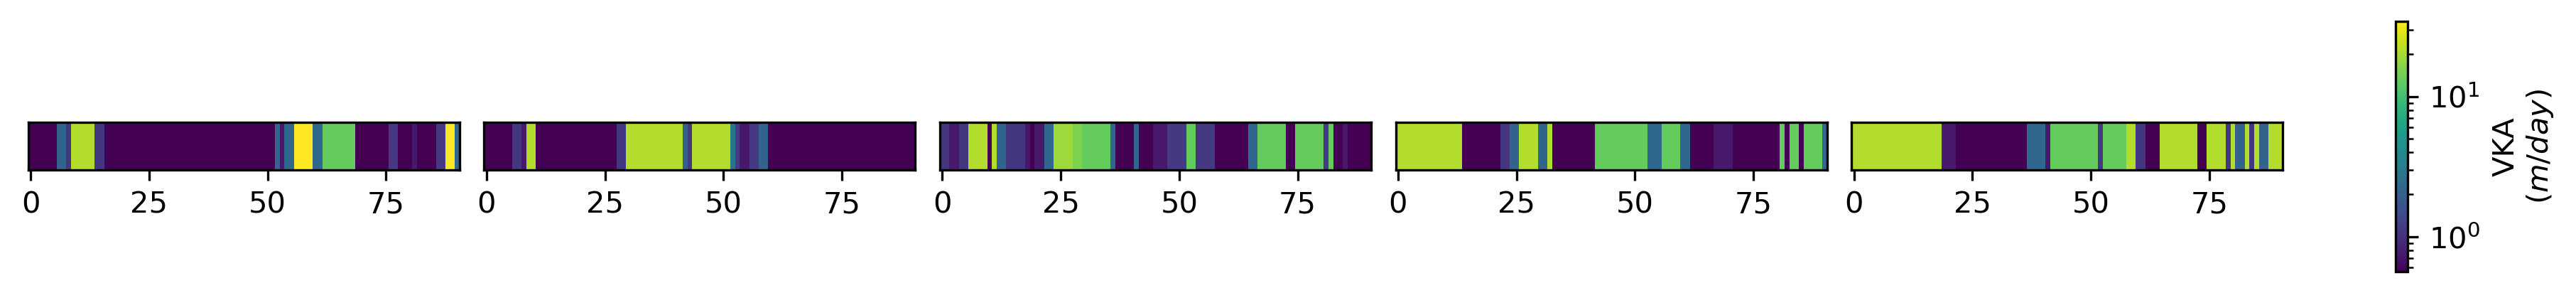

In [32]:
sfr_hk_plt = grid_sfr_all[~grid_sfr_all.iseg.isin(drop_iseg)]
fig,ax = plt.subplots(1, len(q_review), figsize=(12, 4), sharex=True, sharey=True, layout='constrained', dpi=300)
vmin = sfr_hk_plt.strhc1.min()
vmax = sfr_hk_plt.strhc1.max()
for nr, r in enumerate(q_review.realization):

    im = ax[nr].imshow(np.reshape(sfr_hk_plt[sfr_hk_plt.realization==r].strhc1.values, (1,-1)), aspect=10, norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    # plt.xticks([]);
    plt.yticks([]);
cbar_ax=ax.ravel().tolist()
fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=0.3, location='right')    

In [333]:
# the mean hydraulic conductivity does increase slightly as we go up in the number of coarse segments
# sfr_hk_plt.groupby('realization').mean(numeric_only=True).strhc1.loc[q_review.realization]

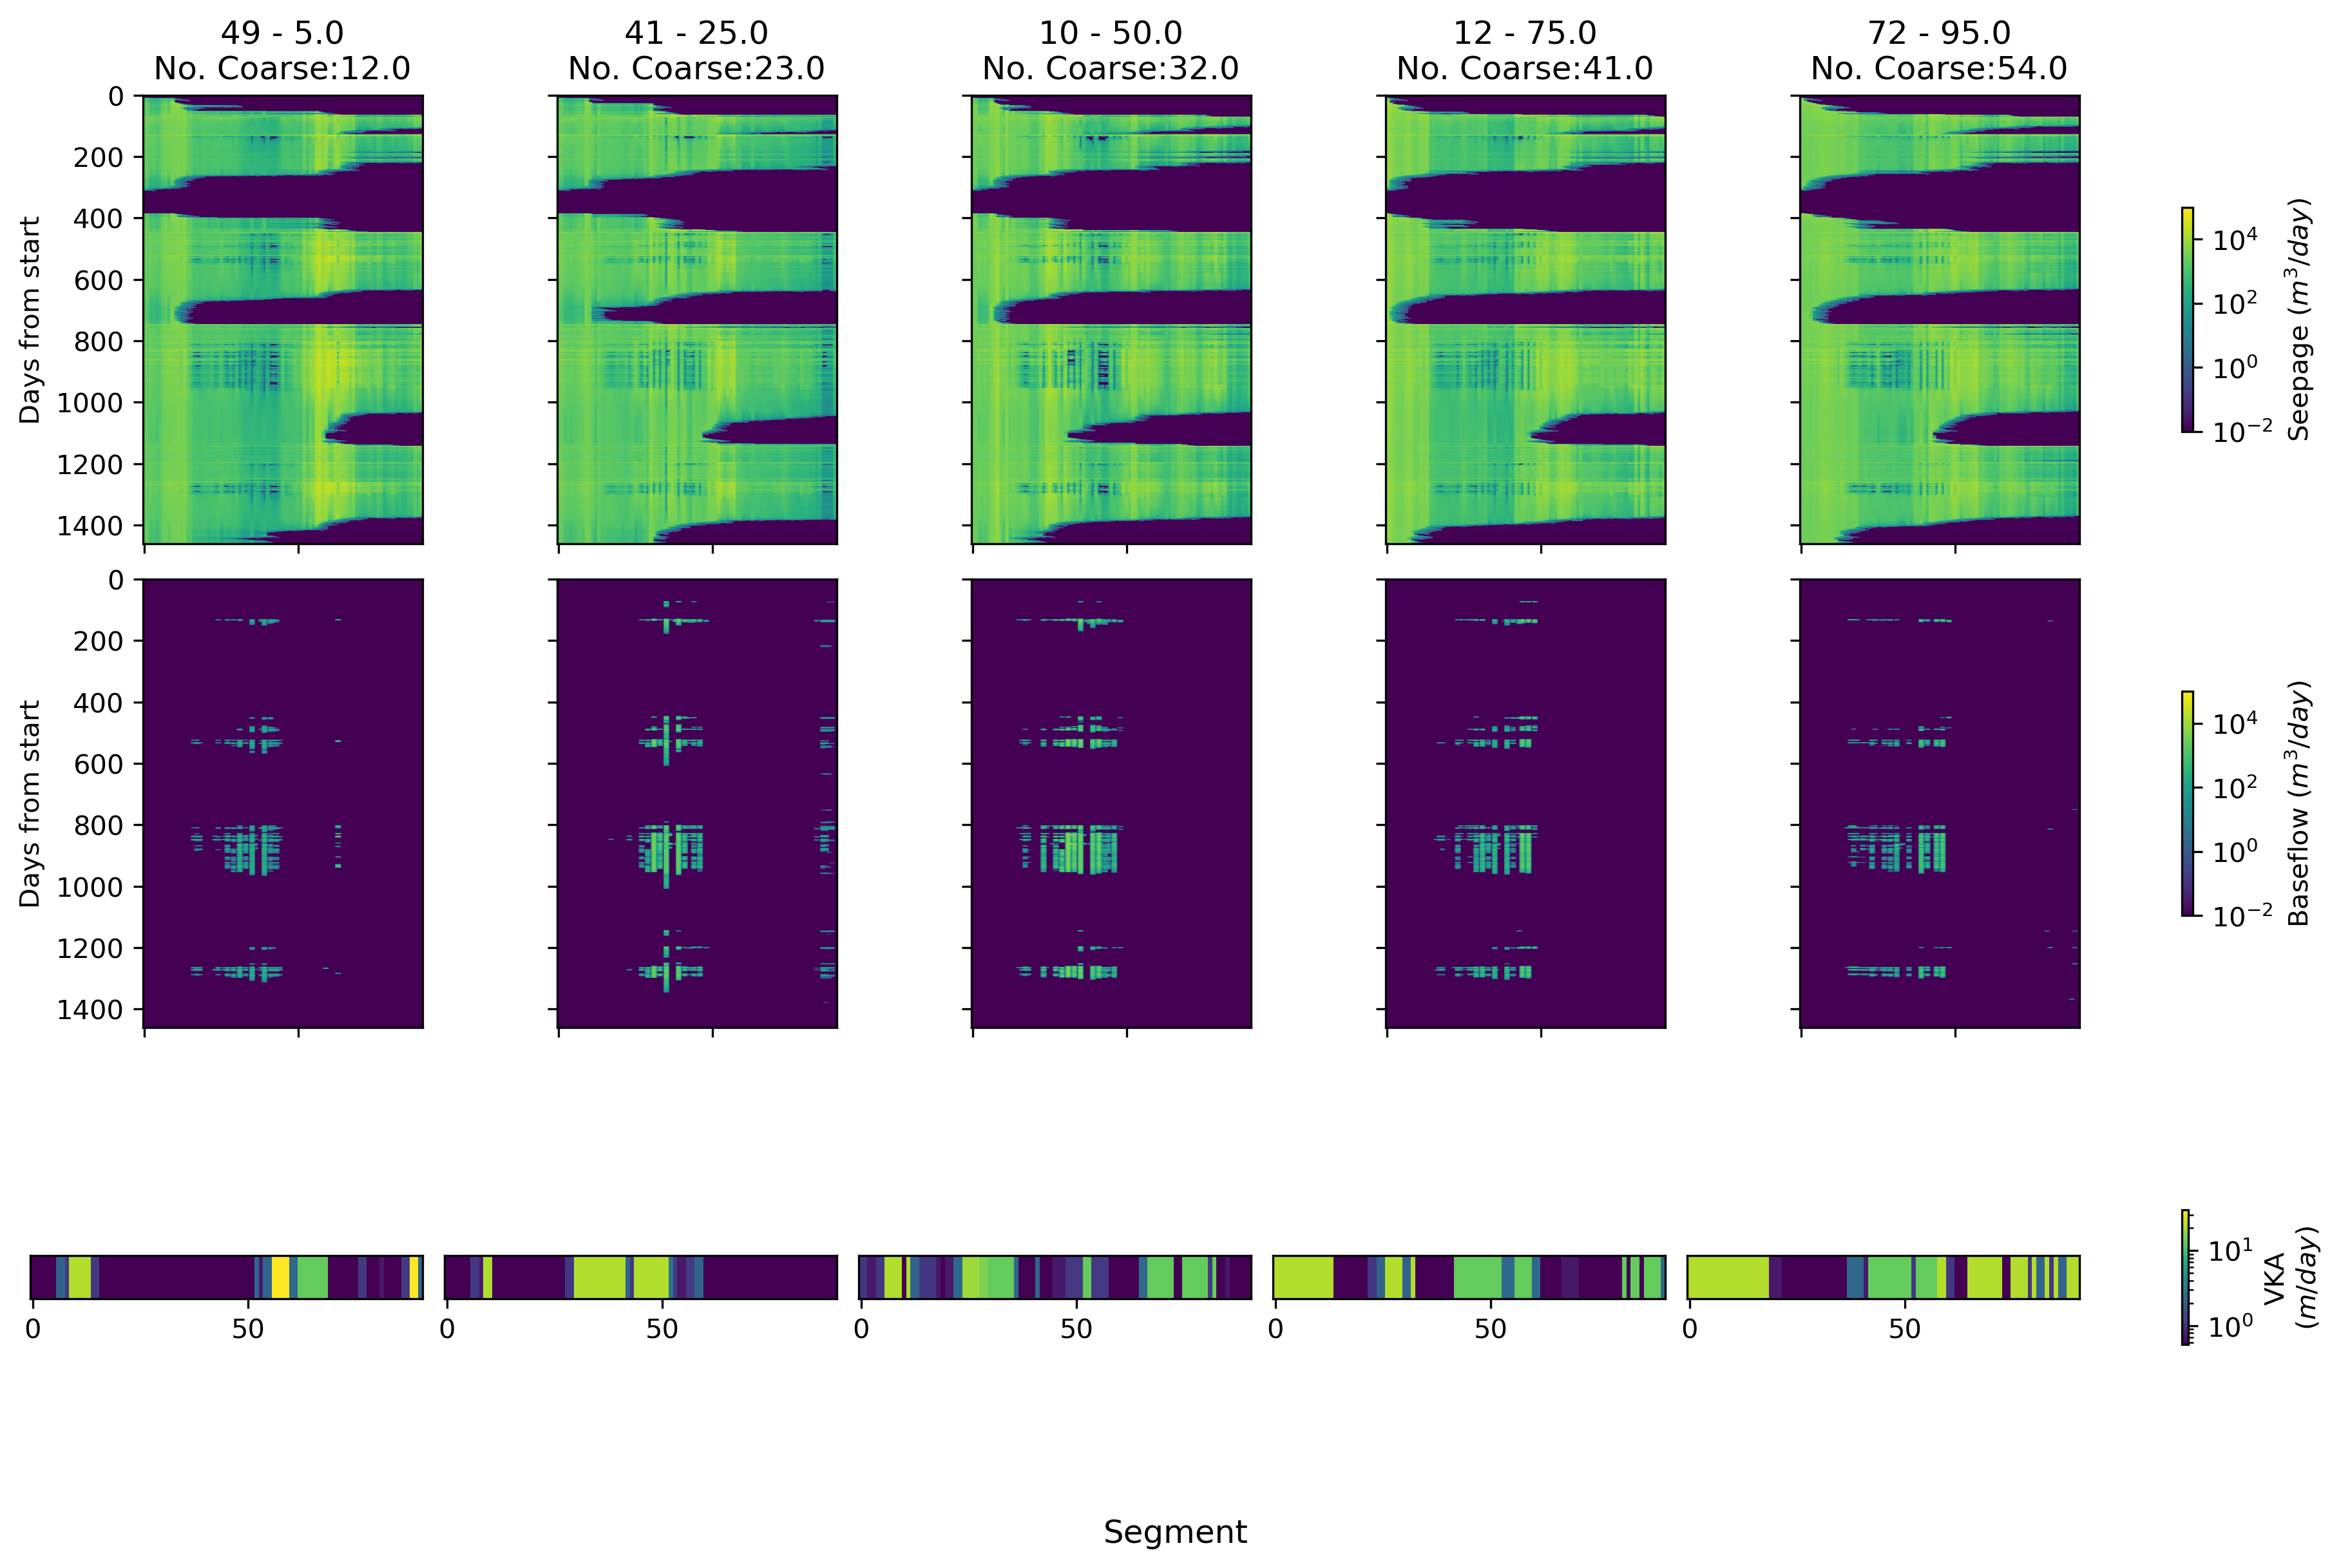

In [63]:
heat_map(sfrdf_all, ['Qrech', 'Qbase'], ['Seepage', 'Baseflow'], q_review)

When it comes to seepage the zones of high streambed conductance align with zones of greater seepage. Downstream zones of higher seepage there are more uniform zones of dry channel proceeding downstream because as flow comes into that zone of high seepage it tends to be used up entirely and their is no downstream baseflow in the dry season to improve flow. We find with the realizations with more coarse segments that the area of dry channel tends to extend further upstream and increase the duration of no streamflow. The periods during the wet season that come across as no seepage are segments with baseflow to the stream.  
The baseflow predominantly occurs along the reconnected floodplain and upstream with a few pockets of baseflow down stream where there is a pocket of high coarse facies, although the duration of baseflow at these pockets is very intermittent. 

- these plots are useful in mapping out how spatial heterogeneity plays a role and the number of facies plays a role

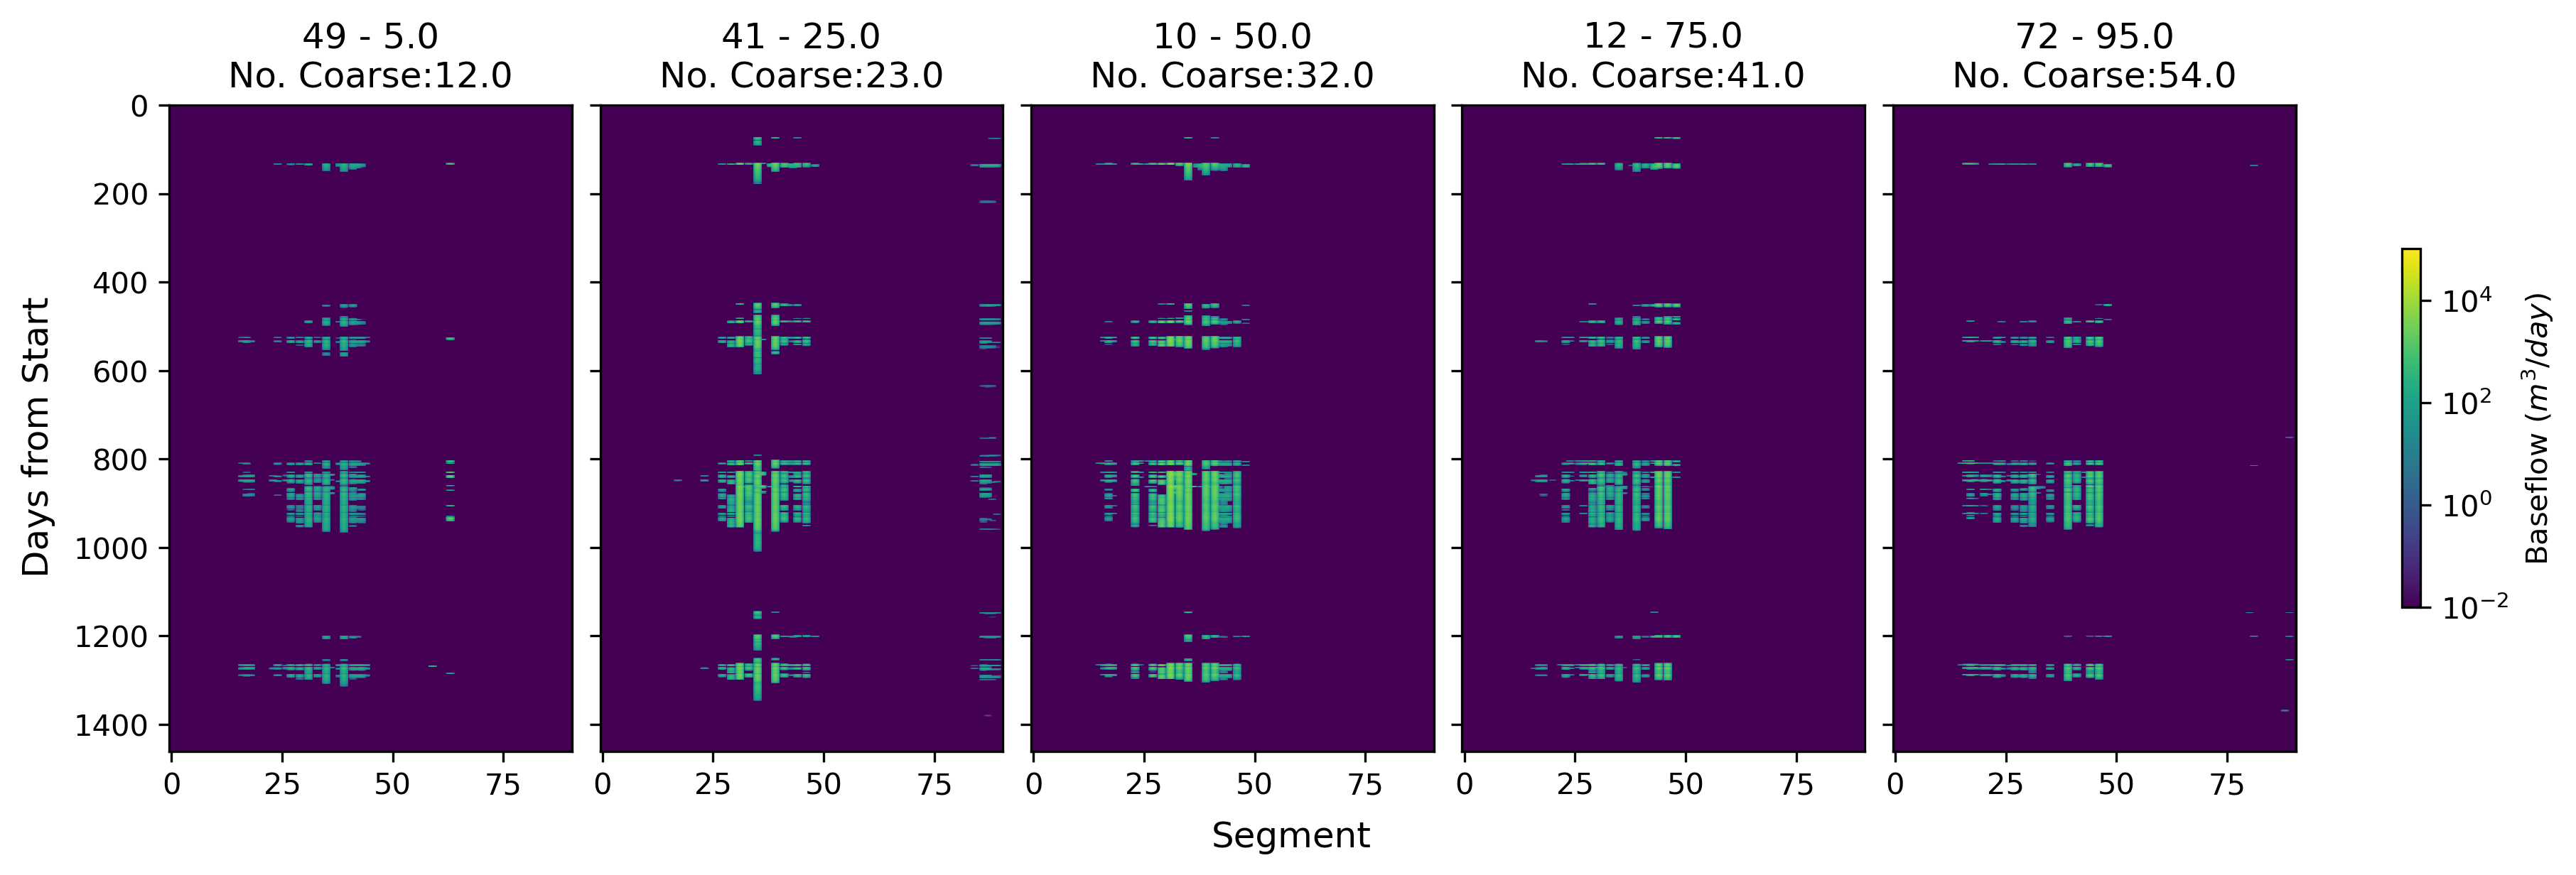

In [34]:
heat_map(sfrdf_all, ['Qbase'], ['Baseflow'], q_review)

In [328]:
# heat map of flow is pretty consitent across segments event with log scale
# heat_map(sfrdf_all, 'Qout', 'Flow', q_review)
# sfrdf

## Segment facies review
Three of the five realizations show the expected behavior of primarily mud with patches of sand, sandy mud and gravel. The outlier is a realization that is probably half gravel and sand as the stream bed facies which is the same realization where there was a huge amount of baseflow in the gravel. There is also a realization that is almost entirely mud with a section of NAs for some reason.  

The realizations with best fit all tend to have dominantly mud in the upper and lower sections with a gravel pocket along the middle section. The other realizations tend to keep this pattern with variability in the length of the gravel section.

In [44]:
lakrow, lakcol = np.where(m.lak.lakarr.array[0].mean(axis=0) >0)
grid_lak = grid_p.set_index(['row','column']).loc[list(zip(lakrow+1,lakcol+1))].reset_index(drop=True)
grid_lak['lake']=True

In [70]:
xs = gpd.read_file(join(proj_dir, 'GIS', 'plotting_cross_section_lines.shp'))
grid_xs = gpd.sjoin(grid_p, xs) # grid cells for each XS

# add info on lake/sfr
grid_xs = grid_xs.join(grid_lak.set_index('node')['lake'], how='left')
grid_xs = grid_xs.join(grid_sfr.set_index('node')[['iseg','strtop','facies', 'k']], how='left')

# set standard cell numbers for XS plotting
for n in  np.arange(0, len(xs)):
    xs_n = grid_xs.loc[grid_xs.id==n].copy().reset_index()
    sfr_cell = xs_n[~xs_n.strtop.isna()].index[0]
    
    grid_xs.loc[grid_xs.id==n, 'xs_cell']  = np.arange(-sfr_cell, len(xs_n)-sfr_cell)


In [261]:
sfr_pts = grid_xs[~grid_xs.iseg.isna()].drop_duplicates('id')
sfr_seg = sfr_pts.iseg.astype(int).values


The time series plots of stream budget at each XS:
- the base only shows for the first XS significantly
- the seepage plot shows some differences between realizations for all XS in either timing or shift up/down
- the difference in Qout is most noticeable with log scale where we can see the difference in dates where flow goes to near 0

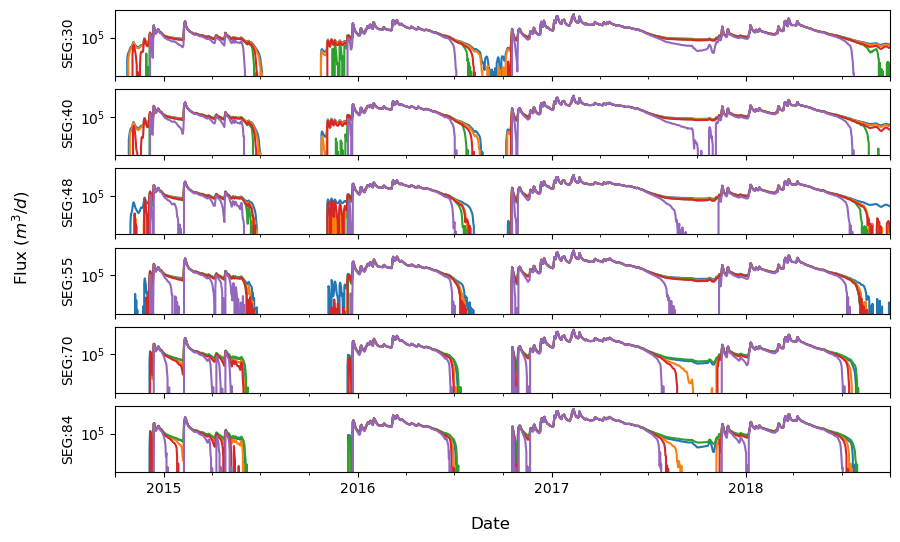

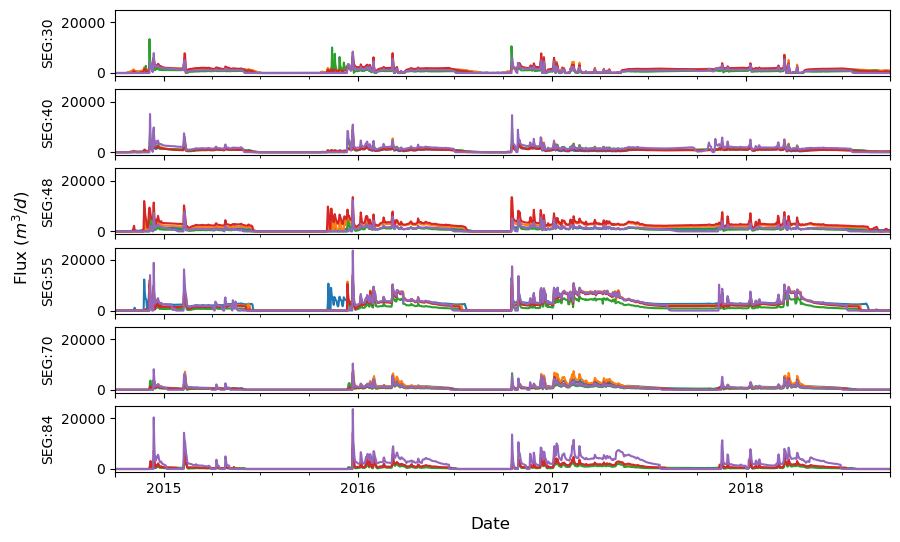

In [339]:
def seg_ts(sfrdf_all, variable):
    fig,ax = plt.subplots(len(sfr_seg), figsize=(10,6), sharex=True, sharey=True)
    for ns, s in enumerate(sfr_seg):
        ax_n = ax[ns]
        if variable in ['Qout']:
            ax_n.set_yscale('log')
        ax_n.set_ylabel('SEG:'+str(s))
        for r in q_review.realization:
            sfrdf = sfrdf_all[sfrdf_all.realization==r]
            sfrdf[sfrdf.segment==s].plot(y=variable, ax=ax_n, legend=False)

    ax[-1].set_xlabel(None)
    fig.supxlabel('Date')
    fig.supylabel('Flux ($m^3/d$)')
    
seg_ts(sfrdf_all, 'Qout')
seg_ts(sfrdf_all, 'Qrech')

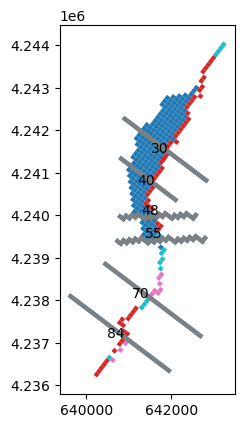

In [263]:
ax=grid_lak.plot()
grid_sfr.plot('facies', ax=ax)
grid_xs.plot(ax=ax)
grid_xs.plot( ax=ax,color='gray')
sfr_pts.apply(lambda x: ax.annotate(str(int(x.iseg)), xy=(x.geometry.centroid.x, x.geometry.centroid.y), ha='right'),axis=1);


It would make sense to have a XS in the middle of the floodplain, at the bottom edge where the gravel patch tends to be in the river and a little further downstream near the outlet.

## Deeper geologic review
Following the segment facies review, there are geologic features that may be adjacent to the channel but not outcrop that could impact flow but this is more difficult to represent. I think plotting these XS with head values and geologic facies are a good way to dive a little deeper at a 2D level. It would also be worthwhile presenting groundwater contours at key points (flood peak, recession and summer low).

In [188]:
r = 11

In [189]:
folder = 'realization'+ str(r).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
# m.model_ws = model_ws
upw_r = flopy.modflow.ModflowUpw.load(model_ws+'/MF.upw', model=m)
# model_ws+'/MF.upw'

In [27]:
def load_r(r):
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    # m.model_ws = model_ws
    upw_r = flopy.modflow.ModflowUpw.load(model_ws+'/MF.upw', model=m)  
    hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
    return(hdobj, upw_r)
hdobj, upw_r = load_r(r)

In [33]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

# dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
# dt_ref['kstpkper'] = kstpkper
# dt_ref

In [362]:
# for n in xs.id:
for n in [2]:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]


In [402]:
# plt.imshow(xs_hk)
xs_hk[0]
ymax = m.dis.top.array.max()
ymin = m.dis.botm.array.min()

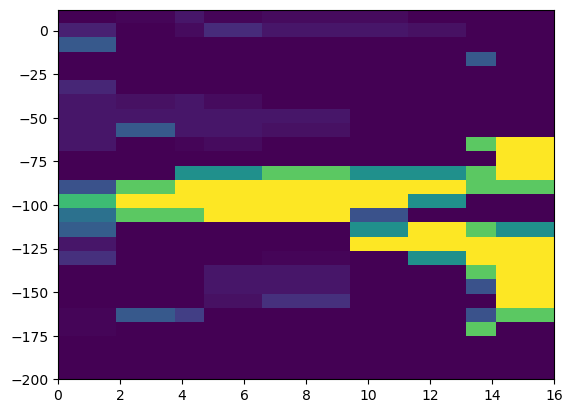

In [404]:
# polygon = ax.fill_between(x, y1, y2, lw=0, color='none')
# ax.margins(x=0.02)
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# verts = np.vstack([p.vertices for p in polygon.get_paths()])
filling = plt.imshow(xs_hk, cmap='viridis', aspect='auto',
                    extent=[xs_n.xs_cell.min(), xs_n.xs_cell.max(), ymin, ymax]
                    # extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()]
                   )
# filling.set_clip_path(polygon.get_paths()[0], transform=ax.transData)
# ax.set_xlim(xlim) # the limits need to be set again because imshow sets zero margins
# ax.set_ylim(ylim)

In [79]:


head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
head = np.ma.masked_where(head==-999.99, head)

# when considering how to plot head we should focus on the upper layers where the river interacts
# it appears the heads under the river/lake stay constant
# for n in np.arange(head.shape[0]):
#     plt.plot(xs_n.xs_cell, head[n]);

def plt_xs_spd(head,  xs_n, ax):
    # plot head in sfr layer only
    sfr_xs_n = xs_n[~xs_n.iseg.isna()] 
    lak_xs_n = xs_n[xs_n.lake==True]
    # plot head in layer connected to sfr (control on seepage)
    head_sfr = head[int(sfr_xs_n.k.values[0])]
    ax.plot(xs_n.xs_cell, head_sfr, color='blue', label='Head in SFR layer')
    # plot average head in upper and lower aquifer
    head_avg = head[0:10].mean(axis=0)
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle='--', label='Average Head - Upper')
    head_avg = head[10:-1].mean(axis=0)
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle='-.', label='Average Head - Lower')
    head_avg = head[-1]
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle=':', label='Head - Deep')

    # plot sfr and lak stages
    ax.scatter(sfr_xs_n.xs_cell, sfr_xs_n.strtop, zorder= -1, color='tab:blue', label='Stream Top')
    ax.scatter(lak_xs_n.xs_cell, lak_xs_n.dem_elev, zorder= -2, color='brown', label='Lake')
    ax.plot(xs_n.xs_cell, xs_n.dem_elev, zorder= -3, color='black', label='Land Surface')
    


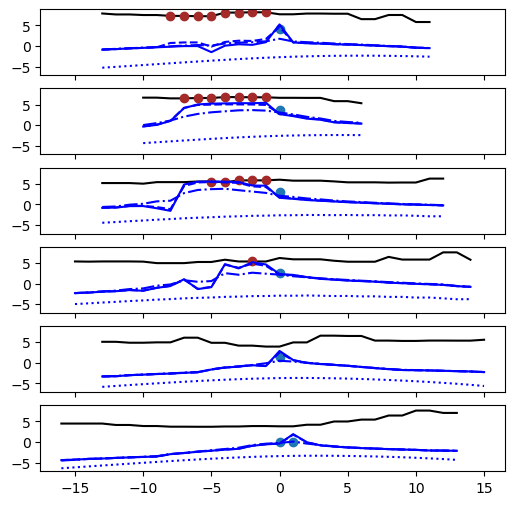

In [80]:
fig, ax = plt.subplots(len(xs.id), figsize=(6,6), sharex=True, sharey=True)
for n in xs.id:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]

    
    head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
    head = np.ma.masked_where(head==-999.99, head)

    plt_xs_spd(head, xs_n, ax=ax[n])

In [ ]:
# is it better to use each stress period or get a time series
# if we use time series then best to just pull heads from sfr layer

In [95]:
sfr_idx = list(zip(np.repeat(int(xs_n[~xs_n.k.isna()].k), len(xs_n)), xs_n.row.values-1, xs_n.column.values-1))

In [97]:
# takes 5ish seconds
hds_ts = hdobj.get_ts(sfr_idx)
hds_ts = np.ma.masked_where(hds_ts==-999.99, hds_ts)


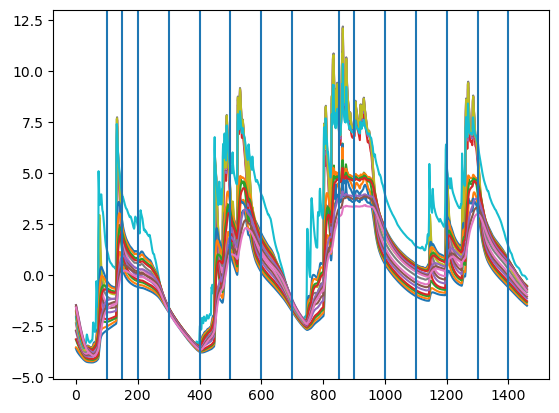

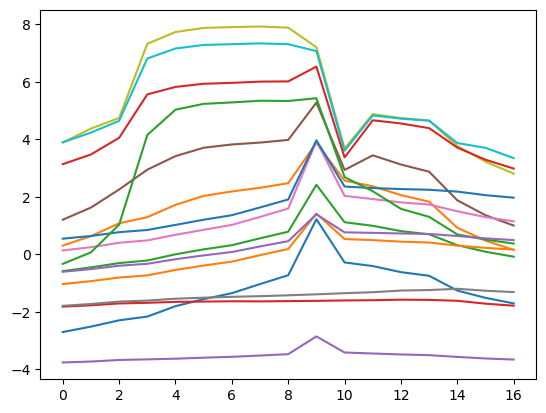

In [124]:
plt.plot(hds_ts[:,1:]);
# need to pick out specific dates of interest
plt_date = np.array([100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000, 1100, 1200, 1300, 1400])
for x in plt_date:
    plt.axvline(x)
    
plt.show()
plt.plot(hds_ts[plt_date,1:].transpose()); # 1400 lines is a lot to visualize, would need to pick specific dates

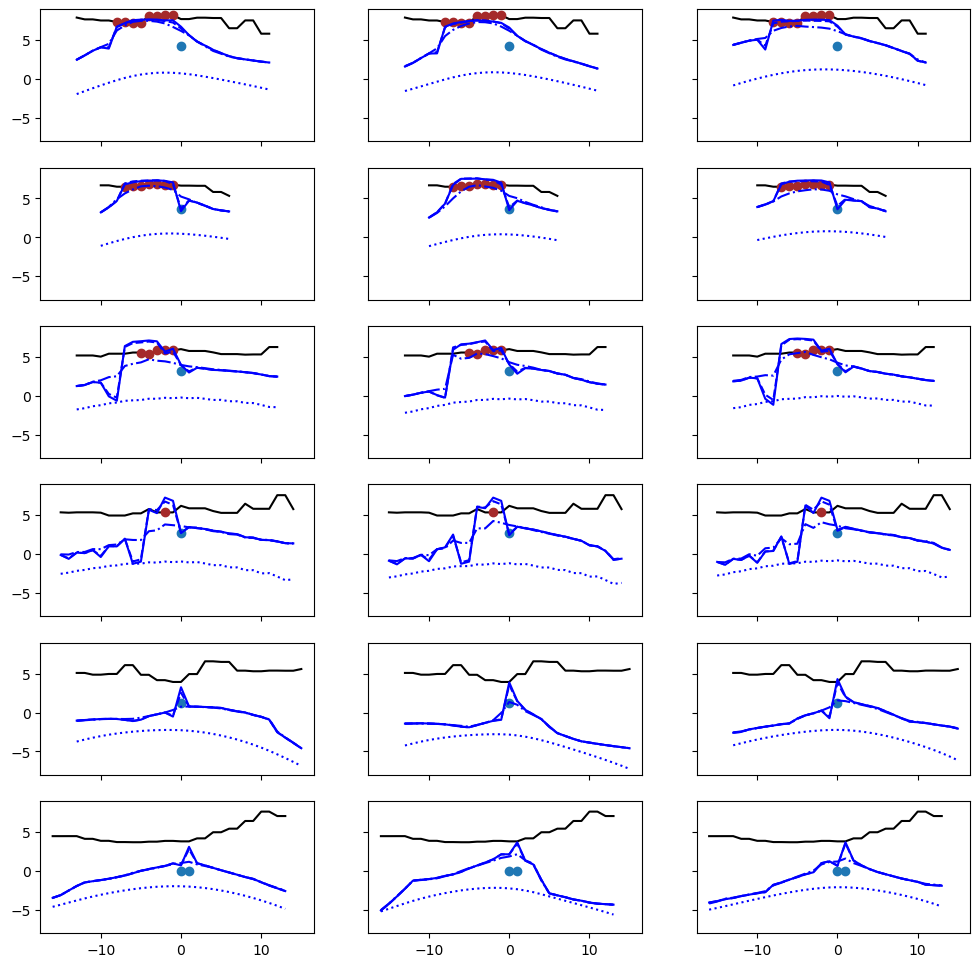

In [125]:
plt_r = r_review[r_review.variable=='fit'].realization
fig, ax = plt.subplots(len(xs.id), len(plt_r), figsize=(12,12), sharex=True, sharey=True)

for nr, r in enumerate(plt_r):
    hdobj, upw_r = load_r(r)

    head = hdobj.get_data(spd_stp[900])
    head = np.ma.masked_where(head==-999.99, head)
    for n in xs.id:
        xs_n = grid_xs[grid_xs.id==n]
        xs_hd = head[:, xs_n.row-1, xs_n.column-1] 
        xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]

        sfr_xs_n = sfr_xs[sfr_xs.id==n]
        lak_xs_n = lak_xs[lak_xs.id==n]


        plt_xs_spd(xs_hd, xs_n, ax=ax[ n, nr ])

Looking at a stress period with a mound due to floodplain recharge (spd=1200) we do see some differences in gradients from the river/floodplain. The differences are pretty slight, e.g., a slightly taller mound or quicker drop off.